<center>
<a href="https://www.vision.rwth-aachen.de/">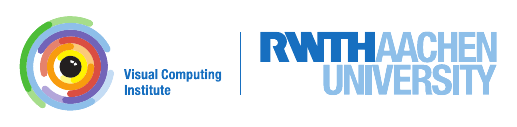</a>
</center>

# Advanced Machine Learning Excercises

**Assistants:**
<br>
Alexey Nekrasov &lt;nekrasov@vision.rwth-aachen.de&gt;
<br>
Jens Piekenbrinck &lt;piekenbrinck@vision.rwth-aachen.de&gt;

The assignments are **NOT** mandatory, but we still encourage you to work on them, in order to gain a deeper understanding.

We want to provide you with an interactive learning experience, so the assignments rely on [Jupyter](https://jupyter.org/) notebooks which you can run locally on your computer. The RWTH also offers a [JupyterHub](jupyter.rwth-aachen.de/) where you can run notebooks. If you have any questions, please contact us.

Make sure you fill in any place in *code cells* that says:
```python
# YOUR CODE HERE
raise NotImplementedError()
```

Make sure you fill in any place in *text cells* that says:
<br>

`YOUR ANSWER HERE`


### Submission:
Before submission remove outputs from the notebooks to prevent sending large files.
With images a hundred submissions could occupy a few GB of space.
To erase the outputs before submission, use a tool [nbstripout](https://github.com/kynan/nbstripout).

Upload all the notebook files with your changes to moodle. **IMPORTANT**: Do not rename files.

⏰ Due date: -

# Exercise 5: Attention Methods and Transformers

## Task: Reimplement the Vision Transformer (ViT)
In this exercise, we ask you to reimplement Vision Transformer.
This work from Dosovitskiy, Beyer, and Kolesnikov achieves state-of-the-art results on classification tasks.
[📄 Paper](https://arxiv.org/pdf/2010.11929.pdf)
Currently, it is one of the most commonly used backbones together with ResNets.

Simply speaking, it consists of three blocks:
1. Linear projection for image patches with positional embedding
2. Transformer Encoder
3. Classification Head

In this exercise, you will implement positional encoding and multi-head attention and train a simple classification network.

We strongly encourage you to read the paper to understand the model.

| <img src="https://miro.medium.com/max/1400/1*l37va2Mu8Snx6LLb13430A.png" width="700" alt="ViT Network Architecture"/> |
|:--:|
| ViT Network Architecture |

As always, we try to write the exercise that you can use a regular laptop to train and run a model.
Please ask for assistance from teaching assistants if you will have any problems.

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

from tqdm.notebook import tqdm

### Set Random seed for reproducibility

In [2]:
seed = 12
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
print("Random Seed: ", seed)

Random Seed:  12


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Dataset and Transformations

We reuse many blocks from GANs and VAEs exercise.

In [4]:
# Size of the generated images (28x28).
image_size = 28

# Creating the transformations
transform = transforms.Compose(
    [transforms.ToTensor()]  # transforms.Normalize((0.5), (0.5))
)

# Define the train and test sets from MNIST data
dset_train = MNIST("./data", train=True, transform=transform, download=True)
dset_test = MNIST("./data", train=False, transform=transform, download=True)

In [5]:
batch_size = 16

# We use DataLoader to get the images of the training set batch by batch.
train_dataloader = DataLoader(dset_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dset_test, batch_size=batch_size, shuffle=True)

### Plotting the dataset

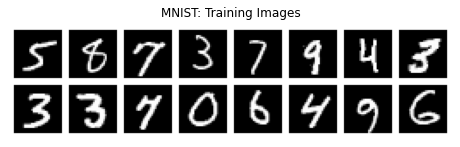

Labels:
[[5 8 7 3 7 9 4 3]
 [3 3 7 0 6 4 9 6]]


In [6]:
# Plot a few MNIST examples

# Load a batch of images into memory
images, labels = next(iter(train_dataloader))
images_grid = make_grid(
    images.view(batch_size, 1, 28, 28),
    padding=4,
    normalize=True,
    pad_value=1,
).cpu()

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("MNIST: Training Images")
plt.imshow(np.transpose(images_grid, (1, 2, 0)))
plt.show()

print("Labels:")
print(labels.reshape(-1, 8).numpy())

### Positional encoding

To encode a position of each patch we add additional unique identifier.

$$
p_{i,j} = 
\begin{cases}
\sin\left(\frac{i}{10000^{\frac{j}{d}}}\right) & \; \text{if } j \text{ is even}\\
\cos\left(\frac{i}{10000^{\frac{j-1}{d}}}\right) & \; \text{if } j \text{ is odd}
\end{cases}
$$

In [7]:
def positional_encoding(seq_len, d):
    # d = embedding dimension
    # seq_len = length of a sequence
    # YOUR CODE HERE
    p = torch.ones(seq_len, d)
    for i in range(seq_len):
        for j in range(d):
            if j % 2 == 0:
                p[i][j] = np.sin(i / np.power(1000, j/d))
            else:
                p[i][j] = np.cos(i / np.power(1000, (j-1)/d))
    
    return p
    # raise NotImplementedError()

Each token gets a different positional encoding, which is highlighted by the horizontal lines.
You could notice that every horizontal line is unique.

Expect to see a similar image:
![positional_encoding.png](positional_encoding.png)

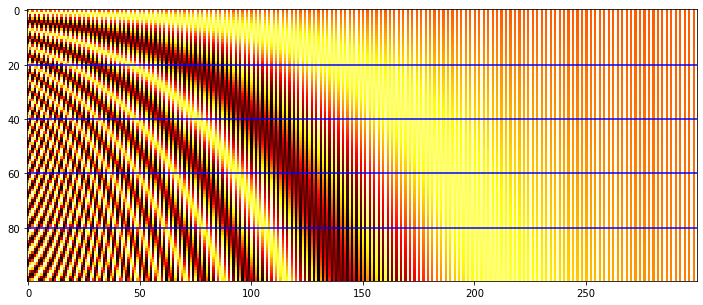

In [8]:
plt.figure(figsize=(12, 5))
plt.imshow(
    positional_encoding(100, 300), cmap="hot", interpolation="nearest", aspect="auto"
)
for y in range(20, 100, 20):
    plt.axhline(y, color="b")
plt.show()

In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, tokens: torch.Tensor) -> torch.Tensor:
        # YOUR CODE HERE
        N = tokens.size(0)
        T = tokens.size(1)
        encoding = positional_encoding(T, self.dim).to(device).repeat(N, 1, 1)
        return tokens + encoding
    
        # raise NotImplementedError()

### Embedding Module

In this module we encode image patches into the tokens.

In [10]:
class Embedding(nn.Module):
    def __init__(self, input_shape, patch_size, out_dim):
        super().__init__()
        # input shape: (C, H, W)
        # patch_size: (H, W)
        assert (
            input_shape[1] % patch_size[0] == 0
        ), "image height has to be divisible by patch height"
        assert (
            input_shape[2] % patch_size[1] == 0
        ), "image width has to be divisible by patch width"

        self.patch_size = patch_size
        self.input_dim = int(input_shape[0] * patch_size[0] * patch_size[1])
        self.out_dim = out_dim

        self.linear_mapper = nn.Linear(self.input_dim, self.out_dim)
        self.cls_token = nn.Parameter(torch.rand(1, self.out_dim))
        self.positional_encoding = PositionalEncoding(self.out_dim)

    def patchify(self, images: torch.Tensor) -> torch.Tensor:
        num_patches = (images.size(2) // self.patch_size[0]) * (
            images.size(3) // self.patch_size[1]
        )
        return (
            images.unfold(2, self.patch_size[0], self.patch_size[0])
            .unfold(3, self.patch_size[1], self.patch_size[1])
            .contiguous()
            .permute(0, 2, 3, 1, 4, 5)
            .view(images.size(0), num_patches, -1)
        )

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        patches = self.patchify(images)

        tokens = self.linear_mapper(patches)

        # adding classification token to every patch
        tokens = torch.stack(
            [torch.vstack((self.cls_token, tokens[i])) for i in range(len(tokens))]
        )

        tokens = self.positional_encoding(tokens)

        return tokens

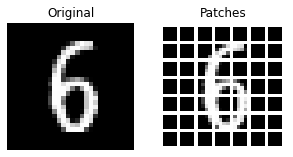

In [11]:
embedding = Embedding((1, 28, 28), (4, 4), 128)

images, labels = next(iter(train_dataloader))
patch_size = (4, 4)  # (H, W)

patches = embedding.patchify(images)
patch_grid = make_grid(
    patches[0].view(patches.size(1), images.size(1), patch_size[0], patch_size[1]),
    padding=1,
    normalize=True,
    pad_value=1,
    nrow=images.size(3) // patch_size[0],
).cpu()

fig, axarr = plt.subplots(1, 2, figsize=(5, 5))
axarr[0].axis("off")
axarr[0].set_title("Original")
axarr[0].imshow(np.transpose(images[0], (1, 2, 0)), cmap="gray")
axarr[1].axis("off")
axarr[1].set_title("Patches")
axarr[1].imshow(np.transpose(patch_grid, (1, 2, 0)))
plt.show()

### Multi-head Self-Attention

In order to ensure local and global information flow ViT uses Multi-head attention that consists of multiple self-attention heads in parallel.

To implement `AttentionHead` refer to [linear layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html), and [softmax](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity).

In [12]:
class AttentionHead(nn.Module):
    def __init__(self, input_dim, head_dim):
        super().__init__()
        # YOUR CODE HERE
        self.scale = head_dim ** 0.5

        self.q_mapping = nn.Linear(input_dim, head_dim)
        self.k_mapping = nn.Linear(input_dim, head_dim)
        self.v_mapping = nn.Linear(input_dim, head_dim)
        self.softmax = nn.Softmax(dim=-1)
        # raise NotImplementedError()

    def forward(self, tokens: torch.Tensor) -> torch.Tensor:
        # YOUR CODE HERE
        q = self.q_mapping(tokens)
        k = self.k_mapping(tokens)
        v = self.v_mapping(tokens)

        attention = (self.softmax(q @ k.T / self.scale)) @ v
        return attention
        # raise NotImplementedError()

In [13]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, n_heads, dim, head_dim):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = head_dim

        self.heads = nn.ModuleList()
        for _ in range(self.n_heads):
            self.heads.append(AttentionHead(self.dim, self.head_dim))

        self.out_projection = nn.Linear(self.n_heads * self.head_dim, self.dim)

    def forward(self, tokens: torch.Tensor) -> torch.Tensor:
        result = []
        for seq in tokens:
            result.append(torch.hstack([head(seq) for head in self.heads]))
        result = torch.cat([torch.unsqueeze(r, dim=0) for r in result])
        return self.out_projection(result)

### Transformer

Transformer encoder block contains MSA, Norm and MLP. Construct a forward pass, check the original paper.

In [15]:
class TransformerBlock(nn.Module):
    def __init__(self, n_heads, dim, head_dim, mlp_dim):
        super().__init__()

        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = head_dim
        self.mlp_dim = mlp_dim

        # 1) Layer normalization 1
        self.ln1 = nn.LayerNorm(self.dim)

        # 2) Multi-head Self-Attention (MSA)
        self.msa = MultiHeadSelfAttention(self.n_heads, self.dim, self.head_dim)

        # 3) Layer normalization 2
        self.ln2 = nn.LayerNorm(self.dim)

        # 4) MLP
        self.mlp = nn.Sequential(
            nn.Linear(self.dim, self.mlp_dim),
            nn.GELU(),
            nn.Linear(self.mlp_dim, self.dim),
        )

    def forward(self, tokens: torch.Tensor) -> torch.Tensor:
        # YOUR CODE HERE
        tokens = tokens + self.msa(self.ln1(tokens))
        tokens = tokens + self.mlp(self.ln2(tokens))
        return tokens
        # raise NotImplementedError()

In [16]:
class Transformer(nn.Module):
    def __init__(self, num_layers, n_heads, dim, head_dim, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            layer = TransformerBlock(
                n_heads=n_heads,
                dim=dim,
                head_dim=head_dim,
                mlp_dim=mlp_dim,
            )
            self.layers.append(layer)

    def forward(self, tokens: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            tokens = layer(tokens)
        return tokens

### ViT Model

We combine all of the blocks together.

In [17]:
class ViT(nn.Module):
    def __init__(
        self,
        input_shape,
        patch_size,
        dim=1024,
        num_layers=1,
        n_heads=8,
        head_dim=64,
        mlp_dim=2048,
        out_dim=10,
    ):
        super().__init__()
        self.dim = dim
        self.head_dim = head_dim
        self.mlp_dim = mlp_dim

        # 1) Embedding
        self.embedding = Embedding(
            input_shape=input_shape,
            patch_size=patch_size,
            out_dim=dim,
        )

        # 2) Transformer Encoder
        self.encoder = Transformer(
            num_layers=num_layers,
            n_heads=n_heads,
            dim=dim,
            head_dim=head_dim,
            mlp_dim=mlp_dim,
        )

        # 3) Classification MLP
        self.cls_mlp = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, out_dim),
        )

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        # embedding -> encoding -> classification
        # YOUR CODE HERE
        tokens = self.embedding(images)
        tokens = self.encoder(tokens)

        cls_token = tokens[:, 0]
        cls_token = self.cls_mlp(cls_token)

        return cls_token
        # raise NotImplementedError()

In [18]:
model: nn.Module = ViT(
    input_shape=(1, 28, 28),
    patch_size=(4, 4),
    dim=16,
    num_layers=1,
    n_heads=2,
    head_dim=16,
    mlp_dim=16,
    out_dim=10,
)
model = model.to(device)

### Loss and Optimizer

In [19]:
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_function = nn.CrossEntropyLoss()

### Training

In [20]:
epochs = 5

train_loss_list = []
test_loss_list = []
accuracy_list = []

for epoch in range(1, epochs + 1):
    ### =====TRAINING=====
    model.train()
    train_loss = 0
    with tqdm(train_dataloader, unit="batch") as train_epoch_pbar:
        for data, labels in train_epoch_pbar:
            train_epoch_pbar.set_description(f"Epoch {epoch}")
            data = data.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            prediction = model(data)
            loss = loss_function(prediction, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_epoch_pbar.set_postfix(loss=loss.item())

        avg_epoch_loss = train_loss / len(train_dataloader.dataset)
        print(
            f"======= Epoch: {epoch} Average Training loss: {avg_epoch_loss:.4f} ======="
        )
        train_loss_list.append(avg_epoch_loss)

    ### =====TESTING=====
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        with tqdm(test_dataloader, unit="batch") as test_pbar:
            for data, labels in test_pbar:
                data = data.to(device)
                labels = labels.to(device)

                prediction = model(data)
                loss = loss_function(prediction, labels)
                test_loss += loss.item()

                correct += torch.sum(torch.argmax(prediction, dim=1) == labels).item()

    test_loss /= len(test_dataloader.dataset)
    print(f"======= Test set loss: {test_loss:.4f} =======")
    test_loss_list.append(test_loss)

    accuracy = correct / len(test_dataloader.dataset)
    print(f"======= Test set accuracy: {accuracy * 100:.2f} =======")
    accuracy_list.append(accuracy)

  0%|          | 0/3750 [00:00<?, ?batch/s]

======= Epoch: 1 Average Training loss: 0.0588 =======


  0%|          | 0/625 [00:00<?, ?batch/s]

======= Test set loss: 0.0309 =======
======= Test set accuracy: 84.24 =======


  0%|          | 0/3750 [00:00<?, ?batch/s]

======= Epoch: 2 Average Training loss: 0.0300 =======


  0%|          | 0/625 [00:00<?, ?batch/s]

======= Test set loss: 0.0278 =======
======= Test set accuracy: 85.61 =======


  0%|          | 0/3750 [00:00<?, ?batch/s]

======= Epoch: 3 Average Training loss: 0.0257 =======


  0%|          | 0/625 [00:00<?, ?batch/s]

======= Test set loss: 0.0220 =======
======= Test set accuracy: 88.18 =======


  0%|          | 0/3750 [00:00<?, ?batch/s]

======= Epoch: 4 Average Training loss: 0.0232 =======


  0%|          | 0/625 [00:00<?, ?batch/s]

======= Test set loss: 0.0200 =======
======= Test set accuracy: 89.70 =======


  0%|          | 0/3750 [00:00<?, ?batch/s]

======= Epoch: 5 Average Training loss: 0.0215 =======


  0%|          | 0/625 [00:00<?, ?batch/s]

======= Test set loss: 0.0191 =======
======= Test set accuracy: 89.84 =======


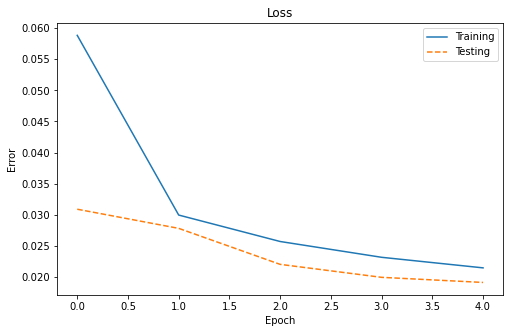

In [21]:
# Plotting
f, axarr = plt.subplots(1, 1, figsize=(8, 5))

# Loss
ax = axarr
ax.set_title("Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Error")

ax.plot(np.arange(epochs), train_loss_list)
ax.plot(np.arange(epochs), test_loss_list, linestyle="--")
ax.legend(["Training", "Testing"])
plt.show()

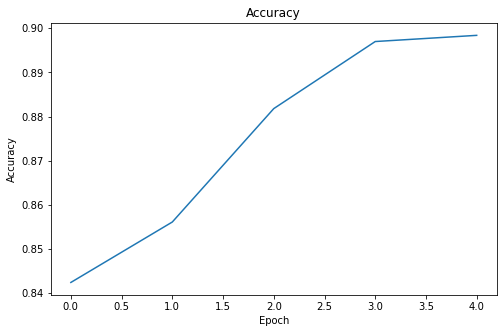

In [22]:
# Plotting
f, axarr = plt.subplots(1, 1, figsize=(8, 5))

# Loss
ax = axarr
ax.set_title("Accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")

ax.plot(np.arange(epochs), accuracy_list)
plt.show()

### Inference

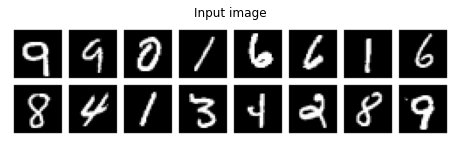

Labels:
[[9 9 0 1 6 6 1 6]
 [8 4 1 3 4 2 8 9]]
Prediction:
[[9 9 0 1 6 6 1 6]
 [8 4 1 0 4 2 8 9]]


In [23]:
with torch.no_grad():
    data, labels = next(iter(train_dataloader))
    data = data.to(device)
    prediction = model(data)

data_grid = make_grid(
    data.view(batch_size, 1, 28, 28),
    padding=4,
    normalize=True,
    pad_value=1,
).cpu()

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Input image")
plt.imshow(np.transpose(data_grid, (1, 2, 0)), cmap="gray")
plt.show()

print("Labels:")
print(labels.reshape(-1, 8).numpy())

print("Prediction:")
print(prediction.argmax(dim=1).reshape(-1, 8).numpy())